<a href="https://colab.research.google.com/github/DinithYM/ML-CW/blob/main/CM2604_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn Prediction

End-to-end churn prediction using Decision Tree and Neural Network on the Telco Customer Churn dataset.


## 1. Libraries and configuration


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

from imblearn.over_sampling import SMOTE
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# plotting + seeds
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

RANDOM_STATE = 42
TEST_SIZE = 0.2

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries imported. RANDOM_STATE =", RANDOM_STATE)


Libraries imported. RANDOM_STATE = 42


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load dataset and initial inspection


In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/ML-CW/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include="all").T)


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data cleaning


In [4]:
# Strip whitespace from string columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Convert TotalCharges to numeric and fill missing values
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Drop customerID if present
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

print("Missing values after cleaning:")
print(df.isna().sum())
df.head()


Missing values after cleaning:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 4. Exploratory Data Analysis (EDA)

### 4.1 Churn distribution


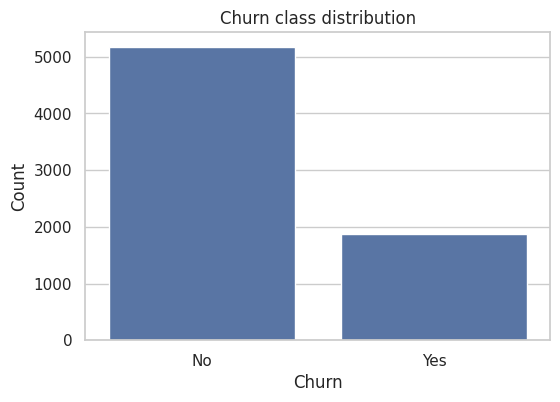

Class proportions:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [5]:
plt.figure()
sns.countplot(x="Churn", data=df)
plt.title("Churn class distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

print("Class proportions:")
print(df["Churn"].value_counts(normalize=True).rename("proportion"))


### 4.2 Numeric feature distributions


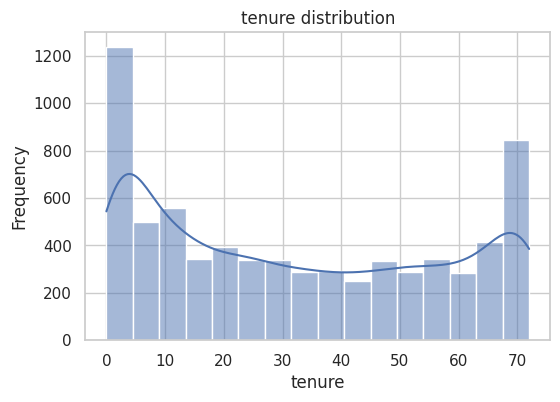

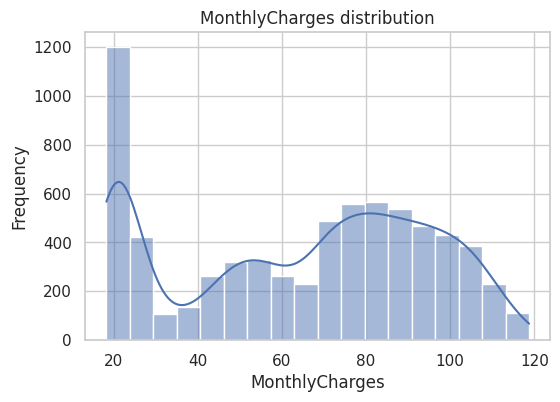

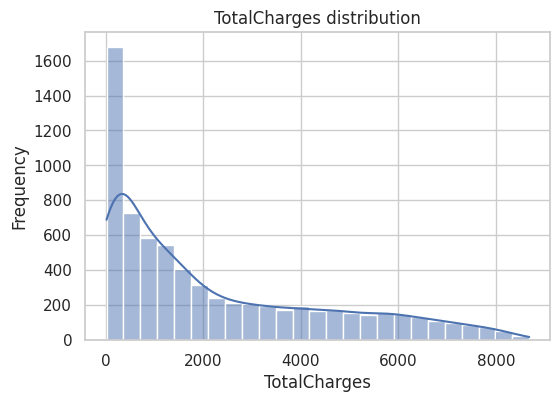

In [6]:
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


### 4.3 Numeric features vs Churn


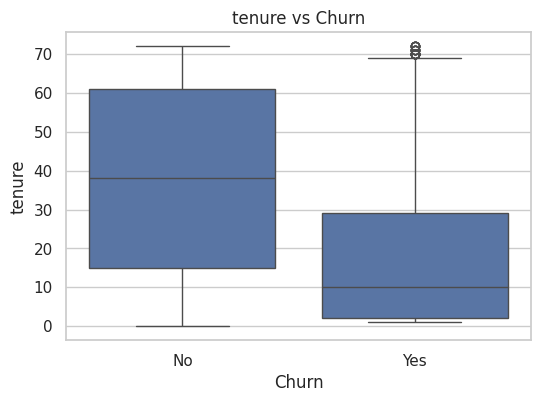

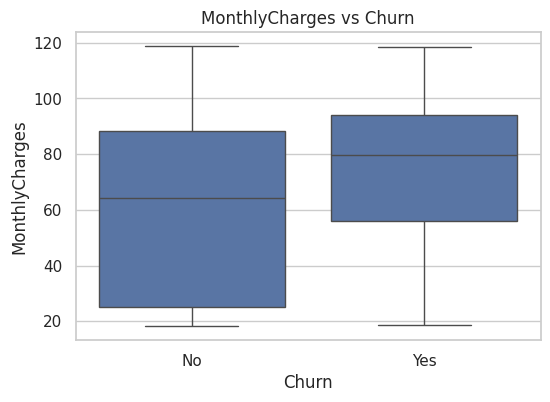

In [7]:
for col in ["tenure", "MonthlyCharges"]:
    plt.figure()
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()


### 4.4 Categorical features vs Churn


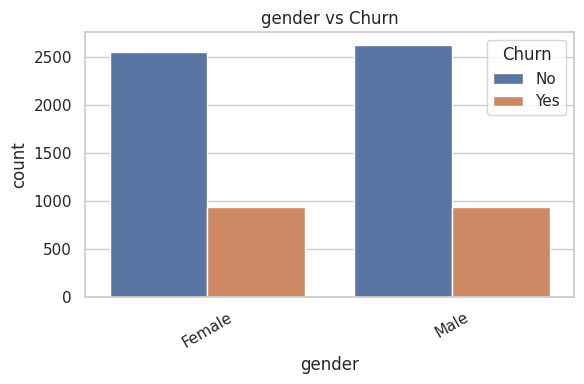

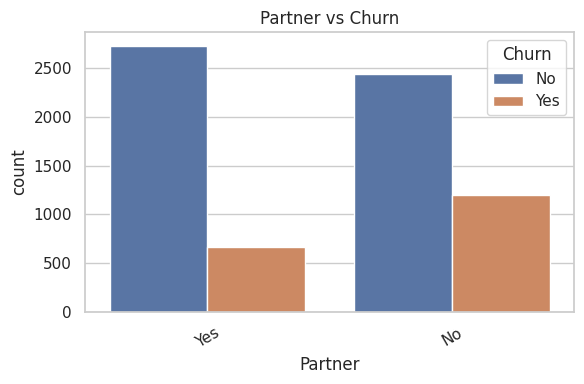

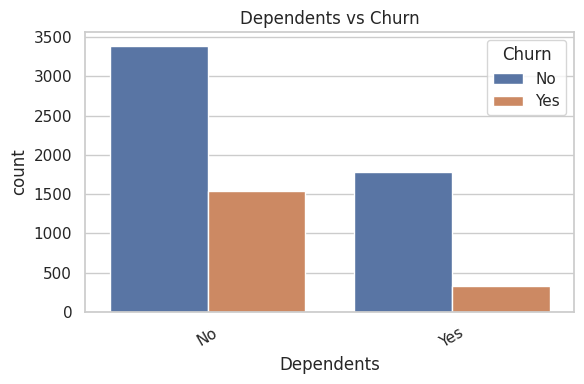

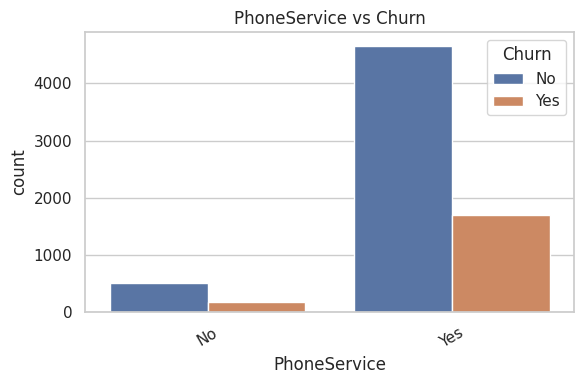

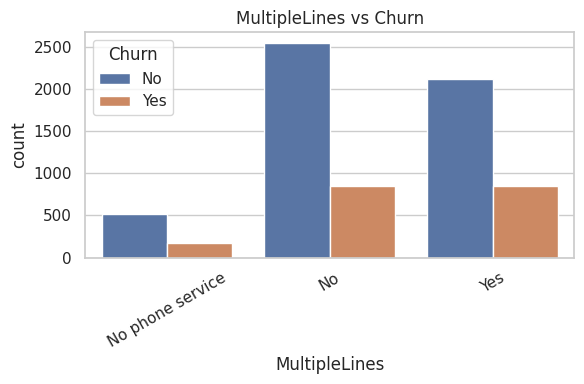

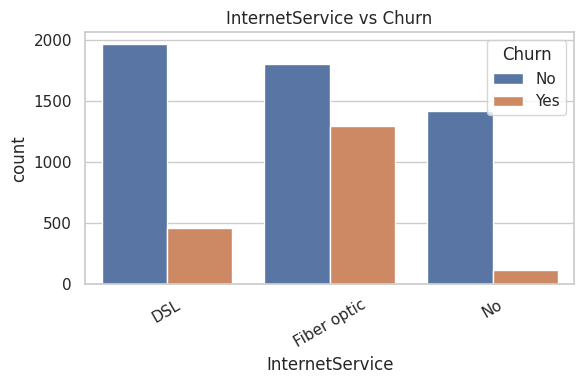

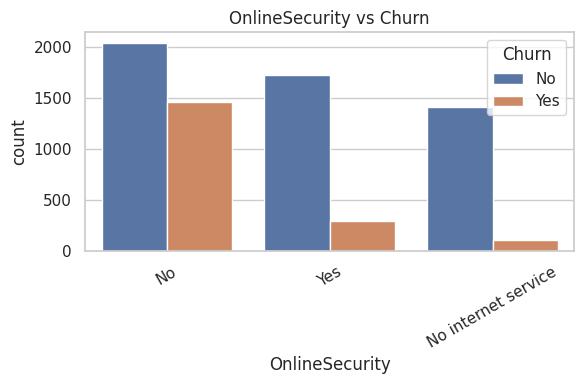

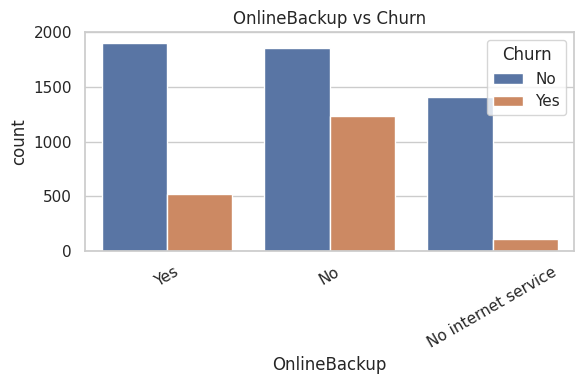

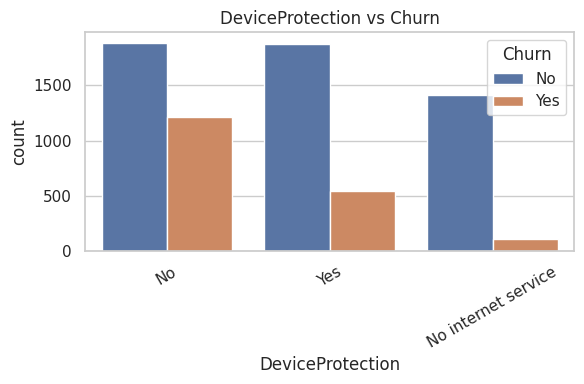

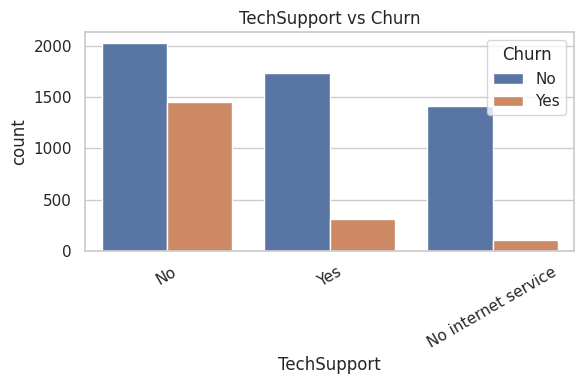

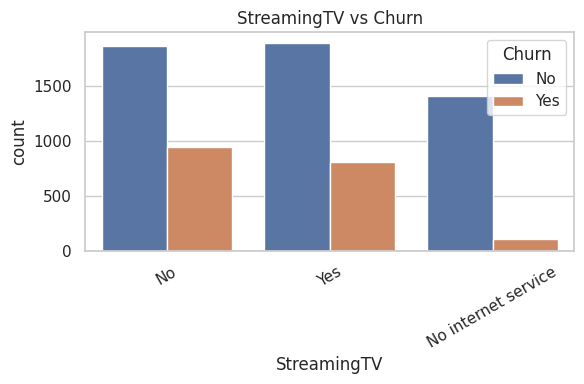

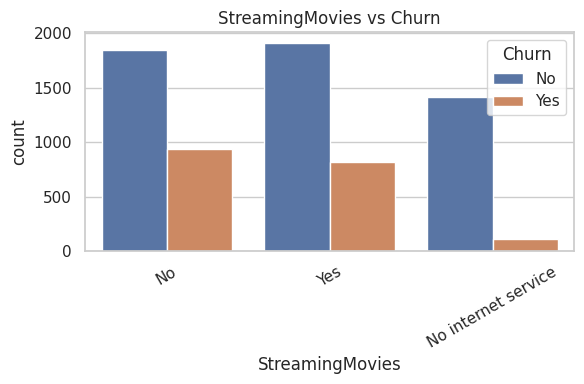

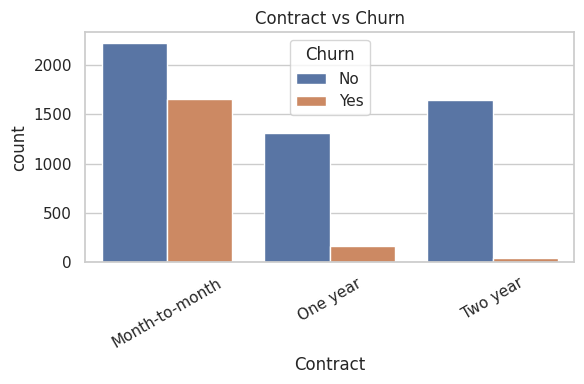

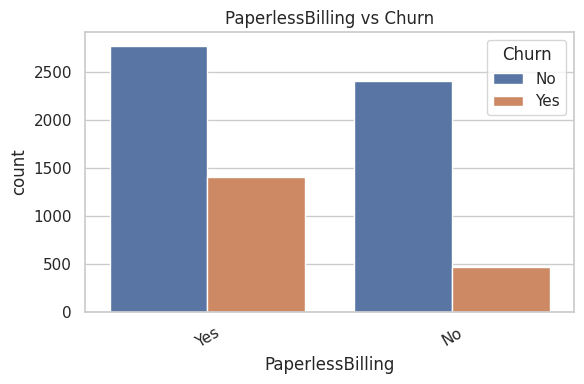

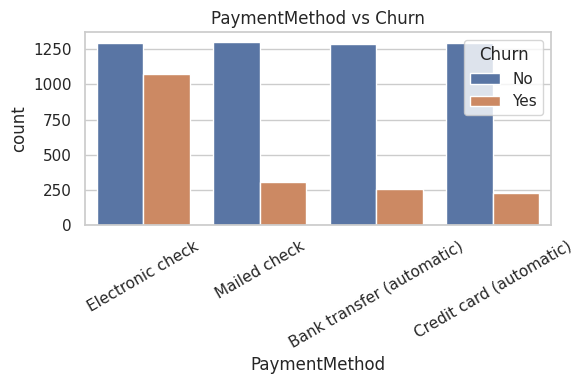

In [8]:
cat_cols = df.select_dtypes(include="object").columns.tolist()
if "Churn" in cat_cols:
    cat_cols.remove("Churn")

for col in cat_cols:
    plt.figure()
    sns.countplot(x=col, hue="Churn", data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


### 4.5 Correlation heatmap (numeric features)


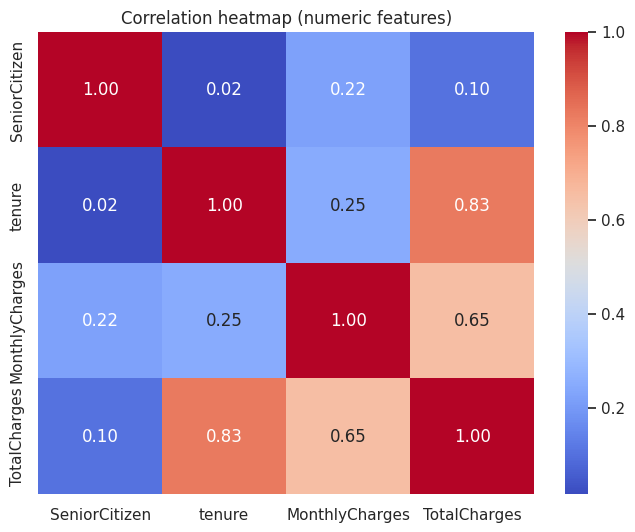

In [9]:
num_only = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 6))
sns.heatmap(num_only.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap (numeric features)")
plt.show()


## 5. Preprocessing and class imbalance handling


In [10]:
# Encode the target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# One hot encode all remaining categoricals
X = pd.get_dummies(df.drop(columns=["Churn"]), drop_first=True)
y = df["Churn"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn proportion:", y_train.mean())


Train shape: (5634, 30) Test shape: (1409, 30)
Train churn proportion: 0.2653532126375577


In [11]:
# SMOTE on training set
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", X_train_res.shape)
print("Resampled churn proportion:", y_train_res.mean())

# Scale for NN only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "telco_scaler.pkl")


After SMOTE: (8278, 30)
Resampled churn proportion: 0.5


['telco_scaler.pkl']

## 6. Decision Tree model


In [12]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_dt = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_res, y_train_res)

best_dt = grid_dt.best_estimator_
joblib.dump(best_dt, "telco_best_dt.pkl")

print("Best DT params:", grid_dt.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best DT params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}


DT Accuracy: 0.7501774308019872
DT ROC-AUC: 0.8103257640342039

DT classification report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1035
           1       0.52      0.65      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409


DT confusion matrix:
 [[814 221]
 [131 243]]


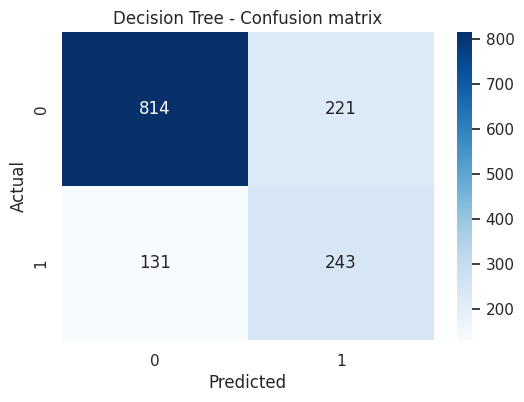

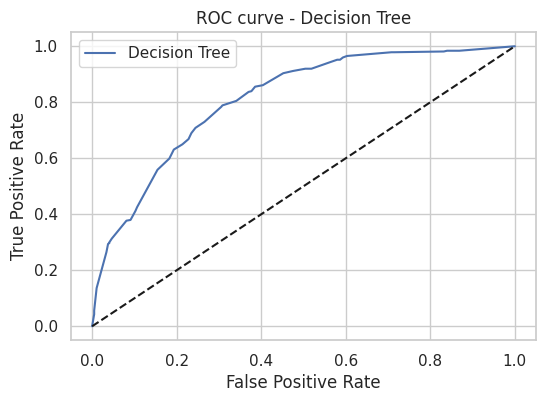

In [13]:
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("DT Accuracy:", accuracy_score(y_test, y_pred_dt))
print("DT ROC-AUC:", roc_auc_score(y_test, y_proba_dt))
print("\nDT classification report:\n", classification_report(y_test, y_pred_dt))
print("\nDT confusion matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Confusion matrix heatmap
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree - Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.figure()
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Decision Tree")
plt.legend()
plt.show()


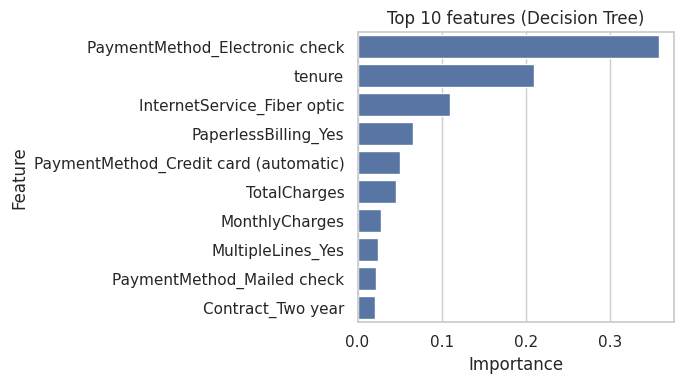

In [14]:
importances = best_dt.feature_importances_
idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(7, 4))
sns.barplot(x=importances[idx], y=X.columns[idx])
plt.title("Top 10 features (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
